In [34]:
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from fuzzy_layer import FuzzyLayer

In [35]:
writer = SummaryWriter(f'runs/mnist/fсvae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')

batch_size = 256
learning_rate = 2e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 3
significant_labels = 10 #количество размеченных классов, вся разметка от 10 и выше считается неразмеченным классом

In [36]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [37]:
# загружаем обучающую выборку
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform=transform,
)
len(train_data)

60000

In [38]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
)
len(test_data)

10000

In [39]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [40]:
class Encoder(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        input_dim (int): Размерность входных данных.
        hidden_dim (int): Размер внутренних слоев.
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(8, 16, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(16, 32, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.SiLU(),  
            nn.Flatten(),
            nn.Linear(9216, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(),  
            nn.Linear(625, 2 * latent_dim), # mean + variance.
        )
        self.softplus = nn.Softplus()
         
    def forward(self, x, eps: float = 1e-8):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """

        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        dist = torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        z = dist.rsample()

        return mu, logvar, z, dist

In [41]:
class Decoder(nn.Module):
    """
    Компонент декодера для VAE
    
    Args:
        input_dim (int): Размерность входных данных.
        hidden_dim (int): Размер внутренних слоев.
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
                
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(), 
            nn.Linear(625, 9216),
            nn.BatchNorm1d(9216),
            nn.SiLU(), 
            nn.Unflatten(1,(64, 12, 12)),
            nn.ConvTranspose2d(64, 32, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(32, 16, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(16, 8, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(8, 1, 5),
            nn.Sigmoid() 
        )
         
    def forward(self, z):
        """
        Декодирует латентный вектор в исходное представление
        
        Args:
            z (torch.Tensor): Латентный вектор.
        
        Returns:
            x
        """

        x = self.decoder(z)
        
        return x

In [42]:
class CVAE(nn.Module):
    """
    Conditional Variational Autoencoder (C-VAE) 
    
    Args:
        input_dim (int): Размерность входных данных.
        hidden_dim (int): Размер внутренних слоев.
        latent_dim (int): Размер латентного вектора.
    """
    def __init__(self, latent_dim, labels_count):
        super(CVAE, self).__init__()

        self.encoder = Encoder(latent_dim)        
        self.decoder = Decoder(latent_dim)

        self.fuzzy = nn.Sequential(
             nn.Linear(latent_dim, latent_dim),
             FuzzyLayer.fromdimentions(latent_dim, labels_count, trainable=True)

        )
        
    def forward(self, x):
        """
        Возвращает компоненты внутренних слоев CVAE, результаты реконструкции и классификации
        
        Args:
            x (torch.Tensor): Входной вектор.
        
        Returns:
            mu, x_recon, labels
        """

        mu, _,  _, _  = self.encoder(x)
        x_recon = self.decoder(mu)
        labels = self.fuzzy(mu)

        return mu, x_recon, labels
    
    def half_pass(self, x):
        """
        Возвращает результаты работы энкодера и классификатора
        """
        mu, logvar, z, dist = self.encoder(x)
        labels = self.fuzzy(mu)

        return mu, logvar, z, dist, labels
    
    def decoder_pass(self, x):
        return self.decoder(x)


In [43]:
def compute_loss(x, recon_x, z, dist, target_labels, predicted_labels):
    loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
    std_normal = torch.distributions.MultivariateNormal(
        torch.zeros_like(z, device=z.device),
        scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
    )
    loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()
            
    weight = torch.where(target_labels >= significant_labels, 0.0, 1.0).to(z.device)
    meaningful = sum(weight, 0).to(z.device)
    ratio = weight.shape[0]/ (meaningful+1).to(z.device)
    filteredLabels = torch.where(target_labels >= significant_labels, 0, target_labels).to(z.device)
    oh = nn.functional.one_hot(filteredLabels, significant_labels).reshape(predicted_labels.shape).to(z.device)
    #print(f"oh {oh.shape}")
    #print(f"predicted_labels-oh {(torch.sum(torch.square(predicted_labels-oh), dim=-1)).shape}")
    #print(f"weight {weight.shape}")
    #print(f"ratio {ratio.shape}")
    loss_fuzzy = ratio * torch.mean(torch.mul(weight, torch.sum(torch.square(predicted_labels-oh), dim=-1)))

    loss = loss_recon + loss_kl #+ loss_fuzzy

    return loss, loss_recon, loss_kl, loss_fuzzy
    

In [44]:
model = CVAE(latent_dim=latent_dim, labels_count=significant_labels).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 11,692,266


CVAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): SiLU()
      (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
      (3): SiLU()
      (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (5): SiLU()
      (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): SiLU()
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=9216, out_features=625, bias=True)
      (11): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): SiLU()
      (13): Linear(in_features=625, out_features=6, bias=True)
    )
    (softplus): Softplus(beta=1, threshold=20)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=3, out_features=625, bias=True)
      (1): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [45]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [46]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    model.train()  
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  
        
        _, _, z, dist, labels = model.half_pass(data)  
        recon_x = model.decoder_pass(z)
        loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, z, dist, target, labels)
        
        loss.backward()
        
        if n_upd % 100 == 0:
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {loss_recon.item():.4f}, KL: {loss_kl.item():.4f} Fuzzy: {loss_fuzzy.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', loss_kl.item(), global_step)
                writer.add_scalar('Loss/Train/Fuzzy', loss_fuzzy.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  
        
    return prev_updates + len(dataloader)

In [47]:
def test(model, dataloader, cur_step, writer=None):
    model.eval() 
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    test_fuzzy_loss = 0
    test_accuracy = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            _, _, z, dist, labels = model.half_pass(data)  
            recon_x = model.decoder_pass(z)
            loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, z, dist, target, labels)
            
            test_loss += loss.item()
            test_recon_loss += loss_recon.item()
            test_kl_loss += loss_kl.item()
            test_fuzzy_loss += loss_fuzzy.item()
            pred_target = np.argmax(labels.cpu().numpy(), axis=1)
            target_labels =  target.cpu().numpy()
            test_accuracy += np.sum(target_labels==pred_target) / len(pred_target)

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    test_fuzzy_loss /= len(dataloader)
    test_accuracy /= len(dataloader)

    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f} Fuzzy: {test_fuzzy_loss:.4f} Accuracy {test_accuracy:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', loss_kl.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/Fuzzy', loss_fuzzy.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/Accuracy', test_accuracy, global_step=cur_step)
        
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decoder_pass(z)
        writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [48]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)

Epoch 1/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 0 (N samples: 0), Loss: 18.2379 (Recon: 17.6175, KL: 0.6205 Fuzzy: 1.2470) Grad: 12.5118
Step 100 (N samples: 25,600), Loss: 7.7737 (Recon: 7.6910, KL: 0.0827 Fuzzy: 1.2990) Grad: 7.6979
Step 200 (N samples: 51,200), Loss: 7.3249 (Recon: 7.3105, KL: 0.0143 Fuzzy: 1.2931) Grad: 10.1027


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4290 (BCE: 7.4217, KLD: 0.0073 Fuzzy: 1.2818 Accuracy 0.0965)
Epoch 2/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 300 (N samples: 76,800), Loss: 7.6216 (Recon: 7.6016, KL: 0.0201 Fuzzy: 1.2928) Grad: 7.1290
Step 400 (N samples: 102,400), Loss: 7.3516 (Recon: 7.3366, KL: 0.0150 Fuzzy: 1.3160) Grad: 2.3155


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3888 (BCE: 7.3803, KLD: 0.0085 Fuzzy: 1.2631 Accuracy 0.0965)
Epoch 3/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 500 (N samples: 128,000), Loss: 7.5642 (Recon: 7.5571, KL: 0.0071 Fuzzy: 1.3013) Grad: 1.4863
Step 600 (N samples: 153,600), Loss: 7.3916 (Recon: 7.3842, KL: 0.0074 Fuzzy: 1.2889) Grad: 3.5200
Step 700 (N samples: 179,200), Loss: 7.4096 (Recon: 7.4042, KL: 0.0054 Fuzzy: 1.2604) Grad: 1.4529


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3859 (BCE: 7.3797, KLD: 0.0061 Fuzzy: 1.2866 Accuracy 0.0965)
Epoch 4/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 800 (N samples: 204,800), Loss: 7.4098 (Recon: 7.4059, KL: 0.0039 Fuzzy: 1.2629) Grad: 1.5975
Step 900 (N samples: 230,400), Loss: 7.4043 (Recon: 7.4030, KL: 0.0013 Fuzzy: 1.3014) Grad: 0.8406


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3777 (BCE: 7.3760, KLD: 0.0017 Fuzzy: 1.2828 Accuracy 0.0965)
Epoch 5/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,000 (N samples: 256,000), Loss: 7.4584 (Recon: 7.4576, KL: 0.0008 Fuzzy: 1.2987) Grad: 1.3637


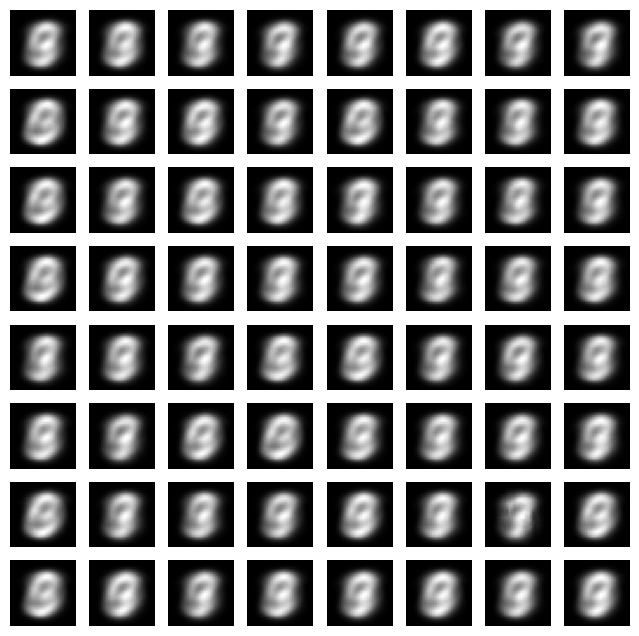

In [ ]:
z = torch.randn(64, latent_dim).to(device)
samples = model.decoder_pass(z)
# samples = torch.sigmoid(samples)

# print first sample
# print(samples[0])

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')

# plt.show()
plt.savefig('vae_mnist.webp')

In [ ]:
# encode and plot the z values for the train set 
model.eval()
z_all = []
y_all = []
pred_y_all = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        mu, x_recon, labels = model.forward(data)
        z_all.append(mu.cpu().numpy())
        y_all.append(target.numpy())
        pred_y_all.append(np.argmax(labels.cpu().numpy(), axis=1))

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

ValueError: The parameter loc has invalid values

In [ ]:
import numpy as np
z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)
pred_y_all= np.concatenate(pred_y_all, axis=0)

In [ ]:
np.sum(y_all==pred_y_all)/len(y_all)

0.1032

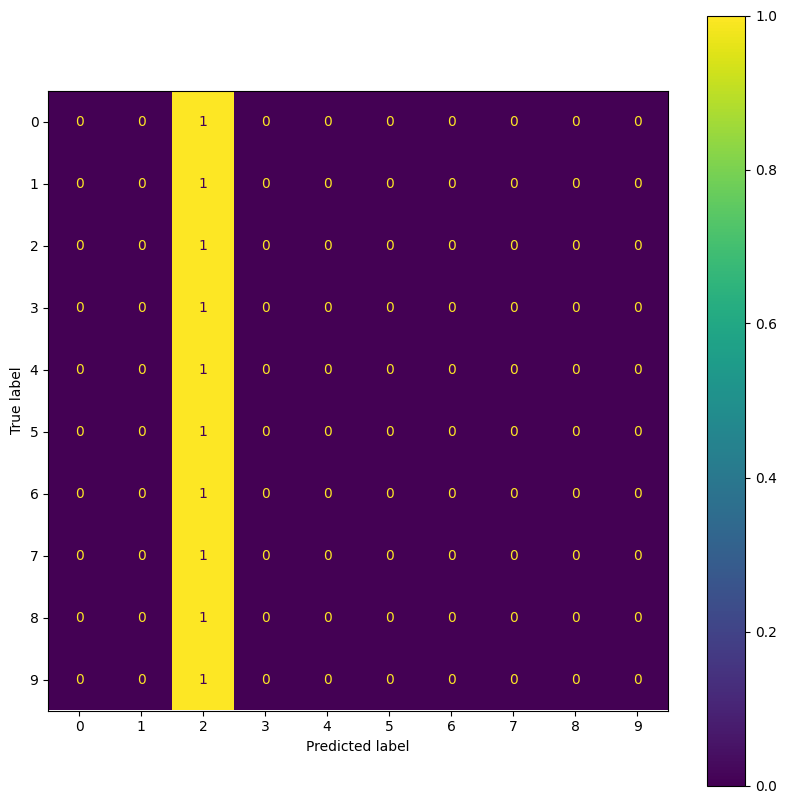

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_all, pred_y_all, normalize='true')
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)

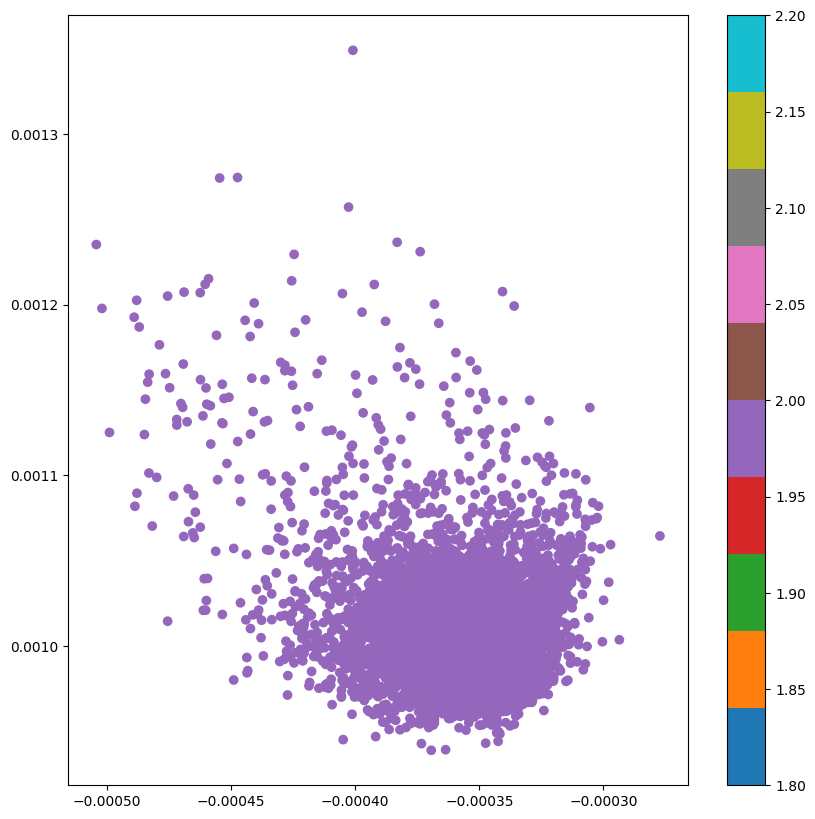

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 0], z_all[:, 1], c=pred_y_all, cmap='tab10')
plt.colorbar()
# plt.show()
plt.savefig('vae_mnist_2d_scatter.webp')

In [ ]:
pred_y_all

array([7, 2, 1, ..., 4, 2, 6], dtype=int64)

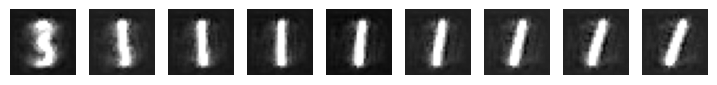

In [ ]:
n = 9
z1 = torch.linspace(-0, 1, n)
z2 = torch.zeros_like(z1) + 1.2
z = torch.stack([z1, z2], dim=-1).to(device)
samples = model.decoder_pass(z)
samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[i].axis('off')
    
plt.savefig('vae_mnist_interp.webp')